# **<font color="#ffb94f">0.0 PREPARATION</font>**

## **<font color="#84f745">0.1 IMPORTS & NOTEBOOK SETUP</font>**

In [6]:
# In case of running on Google Colab
%%capture
# !apt-get install -qq curl g++ make
# !curl -L http://download.osgeo.org/libspatialindex/spatialindex-src-1.8.5.tar.gz | tar xz
# import os
# os.chdir('spatialindex-src-1.8.5')
# !./configure
# !make
# !make install
# !pip install rtree
# !ldconfig
# !pip install scikit-mobility

!pip install geovoronoi
!pip install geopandas
!pip install folium

In [7]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import geopandas as gpd
import folium

from scipy.stats import gaussian_kde, iqr
from scipy.spatial import Voronoi, voronoi_plot_2d
from geovoronoi import voronoi_regions_from_coords, points_to_coords
from shapely.geometry import MultiPolygon, Polygon, Point
from shapely.ops import unary_union

# import skmob
# from skmob.tessellation import tilers
# from skmob.models.epr import DensityEPR, SpatialEPR, Ditras
# from skmob.models.markov_diary_generator import MarkovDiaryGenerator
# from skmob.preprocessing import filtering, compression, detection, clustering
# from skmob.measures.individual import jump_lengths, radius_of_gyration, uncorrelated_entropy, number_of_locations, number_of_visits, location_frequency
# from skmob.measures.collective import visits_per_location
# from skmob.utils.plot import *
# from skmob.data.load import load_dataset, list_datasets

# import sklearn
# from sklearn.metrics import mean_squared_error


In [8]:
# Setting up plot style
sns.set_context(font_scale=2, rc={"font.size":10,"axes.titlesize":16,"axes.labelsize":14})
sns.set_style("whitegrid", {'grid.linestyle': '--', 'alpha': 0.25})
sns.set_style({'font.family':'serif', 'font.serif':'Computer Modern'})

## **<font color="#84f745">0.2 FUNCTIONS</font>**

In [9]:
# Function to produce random points inside a polygon
def polygon_random_points(poly, num_points):
    min_x, min_y, max_x, max_y = poly.bounds
    points = []
    while len(points) < num_points:
        random_point = Point([random.uniform(min_x, max_x), random.uniform(min_y, max_y)])
        if (random_point.within(poly)):
            points.append([random_point.x, random_point.y])
    return np.array(points)

# Function to turn to geodataframe, used in get_voronoi_tessellation
def to_GeoDataFrame(region_polys):
    name=[]
    for i in range(1, len(region_polys) + 1):
        name.append('cell ' + str(i))
    gdf = gpd.GeoDataFrame(columns=['name','geometry'], crs={'init': 'epsg:4326'})
    gdf['name'] = name
    for index, row in gdf.iterrows():
        gdf.at[index, 'geometry'] = region_polys[index]
    return gdf

# Function to obtain voronoi tessellation from a set of points inside a polygon
def get_voronoi_tessellation(poly_ch, points):
    vor = Voronoi(points, qhull_options='Qbb Qc Qx')
    region_polys, region_pts = voronoi_regions_from_coords(points, poly_ch)
    tess_voronoi = to_GeoDataFrame(region_polys)
    return tess_voronoi

# **<font color="#ffb94f">1.0 PREPARING AREAS & TESSELLATIONS</font>**

In [11]:
aqi_points = 'https://raw.githubusercontent.com/Bruno-Limon/air-quality-analysis/main/AQI-2016.csv'
aqi_points_df = pd.read_csv(aqi_points)

aqi_points_df.head(10)

,Fecha,Hora,CO,NO2,O3,PM 10,SO2,PM2.5,Temperatura,Humedad relativa,Velocidad de viento,Direccion de vientos,Radiacion solar,Indice UV,CASETA
0,01/01/2016,0:00:00,1.471,0.02763,0.00472,146.95,0.00306,NaN,18.3,70.3,2.2,270.3,NaN,NaN,ATM
1,01/01/2016,1:00:00,2.653,0.02632,0.00335,216.10,0.00322,NaN,17.3,74.2,0.4,219.5,NaN,NaN,ATM
2,01/01/2016,2:00:00,2.712,0.02698,0.00328,113.44,0.00305,NaN,16.7,76.4,0.6,215.5,NaN,NaN,ATM
3,01/01/2016,3:00:00,2.099,0.02398,0.00348,73.30,0.00259,NaN,16.1,78.4,1.7,250.9,NaN,NaN,ATM
4,01/01/2016,4:00:00,2.019,0.02110,0.00323,52.55,0.00220,NaN,15.7,79.8,0.2,180.6,NaN,NaN,ATM


In [12]:
aqi_points_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87840 entries, 0 to 87839
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Fecha                  87840 non-null  object 
 1   Hora                   87840 non-null  object 
 2   CO                     77138 non-null  float64
 3   NO2                    78519 non-null  float64
 4   O3                     78647 non-null  float64
 5   PM 10                  45142 non-null  float64
 6   SO2                    57942 non-null  float64
 7   PM2.5                  7459 non-null   float64
 8   Temperatura            69318 non-null  float64
 9   Humedad relativa       78099 non-null  float64
 10  Velocidad de viento    86852 non-null  float64
 11  Direccion de vientos   78410 non-null  float64
 12  Radiacion solar        26295 non-null  float64
 13  Indice UV              8784 non-null   float64
 14  CASETA                 87840 non-null  object 
dtypes:

In [13]:
aqi_points_df.describe()

,CO,NO2,O3,PM 10,SO2,PM2.5,Temperatura,Humedad relativa,Velocidad de viento,Direccion de vientos,Radiacion solar,Indice UV
count,77138.000000,78519.000000,78647.000000,45142.000000,57942.000000,7459.000000,69318.000000,78099.000000,86852.000000,78410.000000,26295.000000,8784.000000
mean,0.970973,0.022077,0.023000,49.818858,0.002945,27.059140,22.273478,51.386793,2.827505,159.907881,171.871093,2.083710
std,0.832309,0.014761,0.018882,47.954498,0.087243,18.630563,4.993067,21.782738,2.197647,83.552900,232.705331,3.020985
min,0.001000,0.000550,0.000000,-14.177000,0.000000,0.295000,4.100000,1.800000,0.000000,-1.300000,-0.900000,0.120000
25%,0.518000,0.011280,0.006975,22.790000,0.001770,14.587000,19.000000,34.600000,1.200000,95.400000,6.300000,0.140000
50%,0.744000,0.018480,0.019200,36.090000,0.002320,22.310000,22.000000,50.600000,2.400000,157.500000,15.300000,0.170000
75%,1.114000,0.029225,0.034120,59.710000,0.003000,33.586000,25.700000,68.800000,3.900000,233.000000,322.000000,3.460000
max,12.000000,0.335270,0.523920,1000.200000,21.000000,187.380000,38.000000,114.400000,20.400000,1856.100000,972.200000,13.020000


In [14]:
aqi_points_df['CASETA '].unique()

array(['ATM', 'OBL', 'PIN', 'SFE', 'TLA', 'VAL', 'CEN', 'AGU', 'LDO',
       'MIR'], dtype=object)

In [15]:
aqi_points_df.insert(0, 'Datetime', pd.to_datetime(aqi_points_df['Fecha'] + ' ' + aqi_points_df['Hora']))
aqi_points_df.drop(['Fecha', 'Hora'], axis = 1, inplace = True)

dict_caseta = {'ATM':'Atemajac', 
               'OBL':'Oblatos', 
               'PIN':'Las_Pintas', 
               'SFE':'Santa_Fe', 
               'TLA':'Tlaquepaque', 
               'VAL':'Vallarta', 
               'CEN':'Centro', 
               'AGU':'Aguilas', 
               'LDO':'Loma_Dorada',
               'MIR':'Miravalle'}

aqi_points_df['CASETA '].replace(dict_caseta, inplace=True)
aqi_points_df.head()

,Datetime,CO,NO2,O3,PM 10,SO2,PM2.5,Temperatura,Humedad relativa,Velocidad de viento,Direccion de vientos,Radiacion solar,Indice UV,CASETA
0,2016-01-01 00:00:00,1.471,0.02763,0.00472,146.95,0.00306,NaN,18.3,70.3,2.2,270.3,NaN,NaN,Atemajac
1,2016-01-01 01:00:00,2.653,0.02632,0.00335,216.10,0.00322,NaN,17.3,74.2,0.4,219.5,NaN,NaN,Atemajac
2,2016-01-01 02:00:00,2.712,0.02698,0.00328,113.44,0.00305,NaN,16.7,76.4,0.6,215.5,NaN,NaN,Atemajac
3,2016-01-01 03:00:00,2.099,0.02398,0.00348,73.30,0.00259,NaN,16.1,78.4,1.7,250.9,NaN,NaN,Atemajac
4,2016-01-01 04:00:00,2.019,0.02110,0.00323,52.55,0.00220,NaN,15.7,79.8,0.2,180.6,NaN,NaN,Atemajac


In [27]:
# Official administrative divisions to use as tessellations for each geographical area

url_area = 'https://raw.githubusercontent.com/Bruno-Limon/air-quality-analysis/main/area-ZMG.geojson'

area_base = gpd.read_file(url_area)
area_merged = gpd.GeoSeries(unary_union(area_base['geometry']))

In [28]:
%%capture
dict_tessellations = {}

dict_tessellations['a1_t3'] = gpd.read_file(url_area)
dict_tessellations['a1_t3'].insert(0, 'tile_ID', range(0, len(dict_tessellations['a1_t3'])))
dict_tessellations['a1_t3'] = dict_tessellations['a1_t3'].set_crs({'init': 'epsg:4326'}, allow_override=True)

# Creating polygon of city boundaries for each area using shapely's function unary_union
area_boundary = unary_union(area_merged.geometry)
area_boundary

# Points to build voronoi tessellation for area 
# In the case of area 3, a random approach to produce the points is used to see how it differs from actual points
voronoi_points = polygon_random_points(area_boundary, 50)
points_gdf = gpd.GeoDataFrame(geometry = gpd.points_from_xy(voronoi_points[:,0], voronoi_points[:,1]))

dict_tessellations['a1_t4'] = get_voronoi_tessellation(area_boundary, voronoi_points)
dict_tessellations['a1_t4'] = dict_tessellations['a1_t4'].explode()
dict_tessellations['a1_t4']['tile_ID'] = [str(j) for j in range(1, len(dict_tessellations['a1_t4'])+1)]
dict_tessellations['a1_t4'] = dict_tessellations['a1_t4'].set_crs({'init': 'epsg:4326'}, allow_override=True)

<AxesSubplot:>

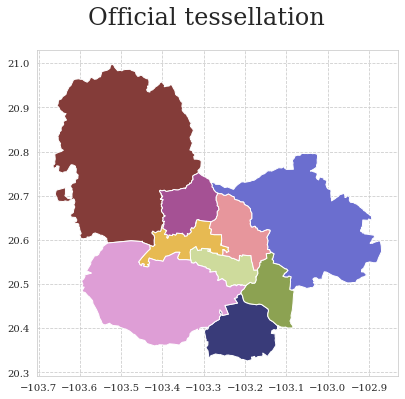

In [29]:
background_color = 'gray'
tess_color = "tab20b"

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6)) 
fig.suptitle('Official tessellation', fontsize = 24)


dict_tessellations['a1_t3'].plot(ax = ax, cmap = tess_color)

<AxesSubplot:>

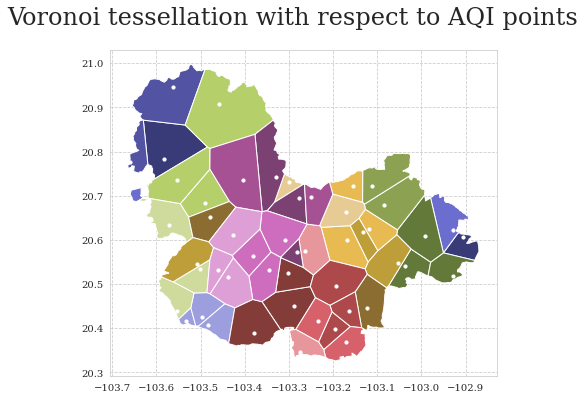

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6)) 
fig.suptitle('Voronoi tessellation with respect to AQI points', fontsize = 24)


dict_tessellations['a1_t4'].plot(ax = ax, cmap = tess_color)
points_gdf.plot(ax = ax, color = 'white', markersize = 10)

In [31]:
# Visualizing trajectories flowing through Area 3
map_f = folium.Map(location=[20.66682, -103.39182], zoom_start=10, tiles='cartodbdark_matter')

# Outlining official tessellation and adding name of counties as folium popup
for _, row in dict_tessellations['a1_t3'].iterrows():
    sim_geo = gpd.GeoSeries(row['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j, style_function = lambda x: {'fillColor': '#98ff69', 'color': 'white'})
    folium.Popup(row['mun_name']).add_to(geo_j)
    geo_j.add_to(map_f)
    
map_f